In [395]:
from sklearn.calibration import CalibratedClassifierCV
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange, tqdm

class ModelBootstrap():
    
    def __init__(self, estimator, n_boot = 100, boot_size = None):
        """
        A class to calibrate classifiers and calculate confidence intervals for classiers.

        estimator:    an estimator with .fit and .predict_proba methods, such as sk-learn classifiers.

        n_boot (int): Number of bootstrap resamples used to estimate the confidence intervals. default: 100

        boot_size:    None or int. if None, each resampled dataset will be the same size as the original dataset. 
                      Otherwise, each resampled dataset will include boot_size samples. default: None
        """
        self.estimator = estimator
        
        if type(n_boot) != int or n_boot < 0:
            raise Warning('n_boot must be an integer larger than 0')
        self.n_boot = n_boot
        
        
        self.boot_size = boot_size
        self.b_estimators = []
        
    def fit(self, X, y, calibration_cv = None):
        """
        A method to fit a calibrated estimator and n_boot bootstrapped estimators.
        
        X: np.array of shape (samples, features).
        
        y: np.array of shape (samples,). Binary classifications.
        
        calibration_cv: int, cross-validation generator for sk-learn CalibratedClassifierCV.
                        see: https://scikit-learn.org/stable/modules/generated/sklearn.calibration.CalibratedClassifierCV.html
        """
        self.calibration_cv = calibration_cv
        
        # Main estimator:
        self.calibrated_estimator = CalibratedClassifierCV(base_estimator = self.estimator, cv = self.calibration_cv)
        self.calibrated_estimator.fit(X, y)
        
        # Bootstrap estimators:
        if self.boot_size == None:
            self.boot_size = X.shape[0]
        
        self.b_estimators = []

        for j in trange(self.n_boot):
            b_idx = np.random.choice(X.shape[0], size = self.boot_size)
            X_resampled = X[b_idx]
            y_resampled = y[b_idx]
            
            partial_estimator = CalibratedClassifierCV(base_estimator = self.estimator, cv = self.calibration_cv)
            partial_estimator.fit(X_resampled, y_resampled)
            self.b_estimators.append(partial_estimator)
            
    def predict(self, X, ci = 95):
        """
        A method to predict a fitted bootstrap model.
        
        X:  np.array of shape (samples, features).
        
        ci: Size of the confidence interval that will be calculated.
            integer between 0 and 100, exclusive. deafult: 95.
        """
        
        # verify the class if fitted:
        if not self.b_estimators:
            raise Warning('Use fit method first')
        
        if type(ci) != int:
            raise Warning('ci must be an integer between 0 and 100 exclusive')
        elif ci <= 0 or ci >= 100:
            raise Warning('ci must be an integer between 0 and 100 exclusive') 
        ci = (1 - ci / 100) / 2
        
        preds = np.zeros((self.n_boot, X.shape[0]))
        y_pred = self.calibrated_estimator.predict_proba(X)[:,1]
        
        for j, est in enumerate(tqdm(self.b_estimators)):
            b_y_pred = est.predict_proba(X)[:,1]
            preds[j] = b_y_pred
        
        lower_bounds = np.quantile(preds, ci, axis = 0)
        upper_bounds = np.quantile(preds, 1 - ci, axis = 0)
        
        return(y_pred, lower_bounds, upper_bounds)
    
    def plot_predict(self, X = np.nan, y = np.nan, lower_bound = np.nan, upper_bound = np.nan, ci = 95, 
                     threshold = 0.5, n_samples = 'all'):
        """
        If X is given, predicts y values using the predict method, and plots the prediction with their 
        corresponding ci% confidence intervals.
        
        X (optional):   np.array of shape (samples, features).
                        If not supplied, y, lower_bound and upper_bound should be supplied.
        
        y (optional):   np.array of shape (samples,). Binary predictions of classifier.
                        Must be supplied if X is not supplied.
                        
        lower_bound (optional): np.array of shape (samples, ). Lower-bound values of y.
                                Must be supplied if X is not supplied.
                                
        upper_bound (optional): np.array of shape (samples, ). Upper-bound values of y.
                                Must be supplied if X is not supplied.
                                
        ci: int between 0 and 100 (exclusive). Confidence intervals to be calculated, in case X is given. default: 95.
        
        threshold: float between 0.0 and 1.0. Threshold for classifying predictions. default: 0.5.
        
        n_samples:  'all' or an integer <= number of samples. If 'all', all samples will be plotted. Otherwise, n_samples 
                    randomly selected samples will be plotted.
                    
        ---
        if X is given, this method will return the prediction outputs (y, lower_bound, upper_bound). 
        Otherwise will return None.
        
        y:           np.array of shape (samples,). Binary predictions of classifier.
        
        lower_bound: np.array of shape (samples, ). Lower-bound values of y.
        
        upper_bound: np.array of shape (samples, ). Upper-bound values of y.
                            
        """
        
        # verify the class if fitted:
        if not self.b_estimators:
            raise Warning('Use fit method first')
        
        # if X is given, predict y, lower_bound and upper_bound using the predict method.
        # otherwise, verify that y, lower_bound and upper_bound are supplied.
        r = False
        if not np.isnan(X).all():
            y, lower_bound, upper_bound = self.predict(X, ci = ci)
            r = True
        elif np.isnan(y).all() or np.isnan(lower_bound).all() or np.isnan(upper_bound).all():
            raise Warning('Either X or y, lower_bound & upper_bound should be supplied')
        results = np.vstack([y, lower_bound, upper_bound]).T
        
        # unless n_samples = 'all', create a sub-sample for plotting with size = n_samples
        if n_samples != 'all':
            if type(n_samples) != int or n_samples > len(y):
                raise Warning("n_samples should be 'all' or an integer <= number of samples")
            else:
                idx = np.random.choice(y.shape[0], size = n_samples)
        else:
            idx = np.arange(y.shape[0])
        
        # mask n_samples samples for plotting.
        results = results[idx]        
        order = np.argsort(results[:,0])
        results = results[order]
        y_binary = (results[:,0] > threshold).astype(int)

        # plot predictions with errorbars
        fig, ax = plt.subplots(figsize = (15,7))
        plt.grid()
        colors = {0: 'blue', 1: 'red'}
        
        for i in [0,1]:
            class_ = np.where(y_binary == i)[0]
            errors = np.vstack([results[:,0][class_] - results[:,1][class_], results[:,2][class_] - results[:,0][class_]])
            ax.errorbar(class_, results[:,0][class_], color = colors[i], 
                         yerr = errors,
                         fmt = 'o',                         
                         ecolor = colors[i], 
                         alpha = 0.4,
                         capsize = 2)
            ax.scatter(class_, results[:,0][class_], color = colors[i], label = i)
        ax.legend() ; ax.set_ylim(-0.05,1.05) ; ax.set_ylabel('prob') ; ax.set_xlabel('sample') ; 
        ax.legend().set_title('Predicted:')
        ax.hlines(threshold, 0, n_samples, color = 'black', ls = '--')
        
        if r:
            return(y, lower_bound, upper_bound) 
        

# Example

In [396]:
from sklearn.ensemble import RandomForestClassifier

n = 100
X = np.random.normal(size = (n, 5))
y = ((X.sum(axis = 1) + np.random.normal(size = n)) > 0).astype(int)

model = RandomForestClassifier(max_depth= 2)
mb = ModelBootstrap(model, n_boot = 20)

mb.fit(X,y)


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:19<00:00,  1.03it/s]


In [397]:
y, lb, ub = mb.predict(X)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.38it/s]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 12.63it/s]


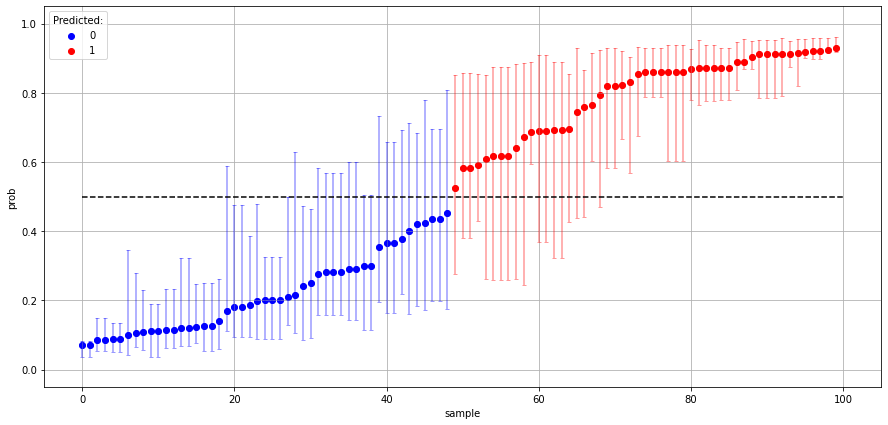

In [398]:
y,l,u = mb.plot_predict(X, n_samples= 100)